In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import json 
import csv

import warnings
import seaborn as sns
import pickle
from collections import Counter

from keras.layers import Dense,Embedding,Input,GlobalMaxPool1D,LSTM,Dropout,Flatten
from keras import Sequential,utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence

from nltk.corpus import stopwords
stop = stopwords.words('english')
from textblob import Word, TextBlob
from gensim.corpora import Dictionary
from gensim.models import Word2Vec,LdaMulticore,TfidfModel
from gensim.models.phrases import Phraser, Phrases
from sklearn.decomposition import PCA
from wordcloud import WordCloud

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC,SVC

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

warnings.filterwarnings("ignore")
%matplotlib inline 

# Defining Functions

In [144]:
def review_metrics(df,text,business_name):
    #create count of number of words
    df["word_count"]=df[text].apply(lambda x: len(str(x).split(" ")))
   
    #create count for number of characters
    df["char_count"]=df[text].str.len()
    
    #average word length
    def avg_word(sentence):
        words = sentence.split()
        return (sum(len(word) for word in words)/len(words))
    
    df["avg_word_len"]=df[text].apply(lambda x: avg_word(x))
    
    #number of stop words
    df["num_stopwords"]=df[text].apply(lambda x:len([x for x in x.split() if x in stop]))
    
    #percentage of non_stop words
    df["non_stop_percent"]= round(1-(df["num_stopwords"]/df["word_count"]),3)
    
    #TextBlob polarity value
    df["polarity"]=df.apply(lambda row: TextBlob(row[text]).sentiment.polarity, axis=1)
    
    #TextBlob subjectivity value
    df["subjectivity"]=df.apply(lambda row: TextBlob(row[text]).sentiment.subjectivity, axis=1)
    
    
    sns.countplot(data.stars)
    plt.title("Number of review by Stars")
    plt.savefig("./images/number_of_reviews.png")
    plt.show()
    
    plots=["word_count","char_count","avg_word_len",
                  "num_stopwords","non_stop_percent",
           "polarity","subjectivity"]
    
    for plot in plots: 
        graph = sns.FacetGrid(data=data,col='stars')
        graph.fig.suptitle(plot + " by number of stars",fontsize=12,y=1.05)
        graph.map(sns.violinplot,plot,palette="Set2", 
                           inner="quartile")
        plt.subplots_adjust(top=0.9,hspace=0.4, wspace=0.4)
        graph.savefig("./images/"+business_name+"_violinplot_"+plot+".png")
    
    sns.set(style="white")


    # Compute the correlation matrix
    corr = df[plots].corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title("Correlation Graph")
    plt.savefig(business_name+"_Correlation_graph.png")
    plt.show()
    
    return df

In [145]:
def generate_wordcloud(df,text,num_words,business_name):
    w2v_model=Word2Vec(df[text],size=100,window=5,min_count=2)
    w2v_model.save("./models/word2vec_"+business_name+".model")
    words_nonstop = dict()
    for item in w2v_model.wv.vocab:
        words_nonstop[item]=w2v_model.wv.vocab[item].count
    word_cloud = WordCloud(width = 2000, 
                           height = 1200,
                           max_words=num_words,
                           background_color='white',
                           contour_width=3,
                           contour_color="orange").generate_from_frequencies(words_nonstop)
    plt.figure(figsize=(20,20))
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.title("Frequency Wordcloud")
    plt.savefig("images/"+business_name+"_wordcloud.png")
    plt.show();

In [146]:
def clean_review(df,text,business_name):
    
    df[text] = df[text].apply(lambda x: " ".join(x.lower() for x in x.split()))
    
    df[text] = df[text].str.replace("[^\w\s]","")
    
    df[text] = df[text].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    
    df[text] = df[text].apply(lambda x: str(x).split(" "))
    
    bigram = Phrases.load('./models/bigram_phraser_initial')
    
    df[text] = bigram[df[text]]
    
    trigram = Phrases.load('./models/trigram_phraser_initial')
    
    df[text] = trigram[df[text]] 
    
    generate_wordcloud(data,"review",1000,business_name)
                                  
    return df

In [147]:
def get_themes(df,text,y_test,star):
    print("Themes within "+str(star)+" star reviews")
    print("------------")
    star_reviews=df[text].loc[y_test == star]
    common_dictionary = Dictionary(star_reviews)
    common_dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)
    common_corpus = [common_dictionary.doc2bow(text) for text in star_reviews]
    tfidf = TfidfModel(common_corpus)
    corpus_tfidf = tfidf[common_corpus]
    lda_model=LdaMulticore(corpus_tfidf,num_topics=4,id2word=common_dictionary, passes=50, workers=4)
    for idx, topic in lda_model.print_topics():
        print('Topic: {} \nWords: {}'.format(idx, topic))
        
    topics = lda_model.show_topics(formatted=False)
    data_flat = [w for w_list in df[text] for w in w_list]
    counter = Counter(data_flat)

    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i , weight, counter[word]])

    df_trigram = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(2, 2, figsize=(10,10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height="word_count", data=df_trigram.loc[df_trigram.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df_trigram.loc[df_trigram.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax_twin.set_ylim(0, 0.30); ax.set_ylim(0, 500)
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df_trigram.loc[df_trigram.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)    
    fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)   
    plt.savefig("yelp_keyword_graph_"+str(star)+"_star.png")
    plt.show()
    
    plot = pyLDAvis.gensim.prepare(lda_model, common_corpus, dictionary=lda_model.id2word)
    pyLDAvis.save_html(plot, "lda_"+str(star)+"_star.html")
    plot


In [148]:
def prepare_dataset(df,text,y_test,business_name):
    review_metrics(df,text,business_name)
    clean_review(df, text,business_name)
    get_themes(df,text,y_test,1)
    get_themes(df,text,y_test,5)
    df[text]=df[text].apply(lambda x: "".join(str(x)))
    tf=pickle.load(open("./models/tfidf1.pkl", 'rb'))
    return tf.transform(data["review"])

In [149]:
def get_labels(df,text,business_name,model_1,model_2,y_test,cv=10):
    review=prepare_dataset(df,text,y_test,business_name)
    print("---------------")
    print("Text Shape: {}".format(review.shape))
    # load the model from disk           
    model_a = pickle.load(open(model_1, "rb"))
    model_b = pickle.load(open(model_2, "rb"))

    prediction_1 = model_a.predict(review)
    prediction_2 = model_b.predict(review)
    y_model = np.round(0.66*prediction_1+0.33*prediction_2,0)
    print("---------------")
    print("Model Accuracy: {:.4}%".format(np.mean(y_model==y_test)*100))
    print("---------------")
    print("Model Evaluation")
    print(metrics.classification_report(y_model, y_test))
    

# Testing my model

In [150]:
data=pd.read_csv("business_1.csv")

In [151]:
data.head(5)

,name,stars,review
0,Keith L.,4.0,"I am basing this review after one visit, so th..."
1,Cianni E.,4.0,I was hangry one Sunday late afternoon looking...
2,Eric D.,5.0,Service in a Sunday Brunch was excellent. I ha...
3,Jess L.,4.0,My husband and I were able to snag a happy hou...
4,Ted R.,4.0,The Beer Baron's a good spot on College with a...


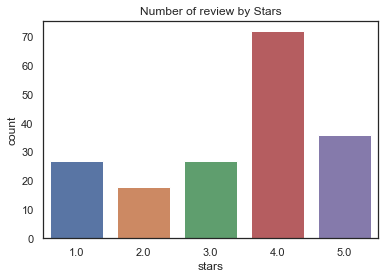

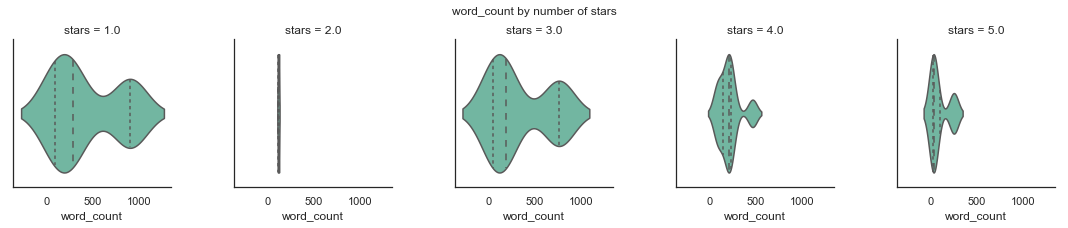

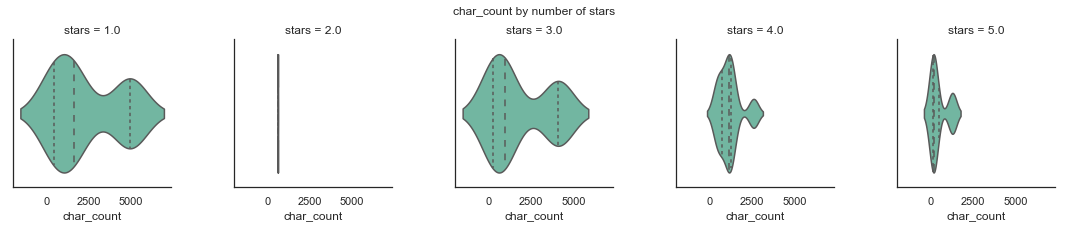

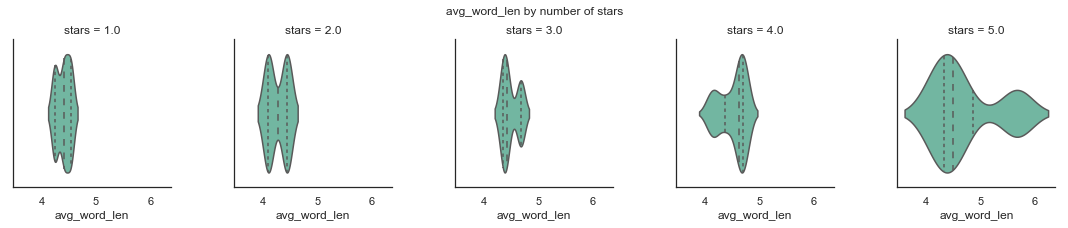

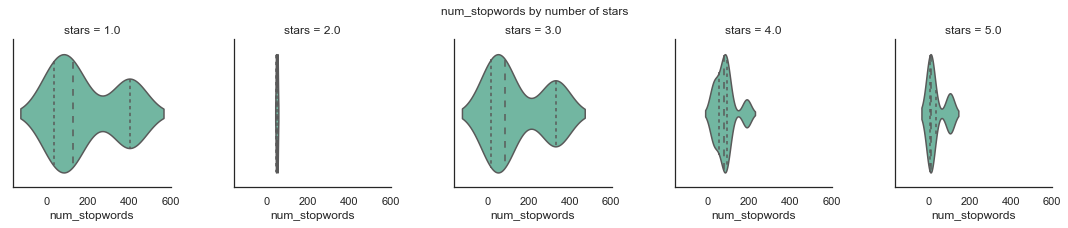

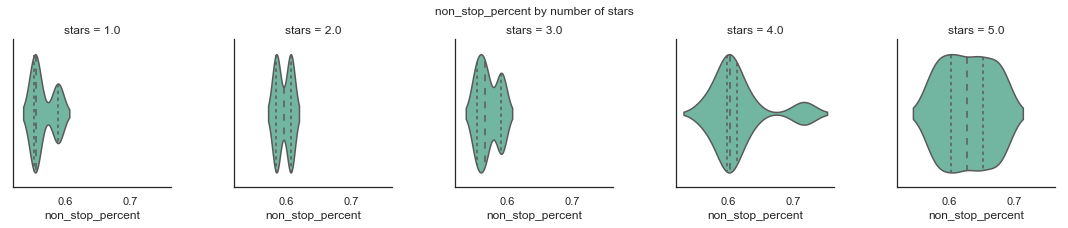

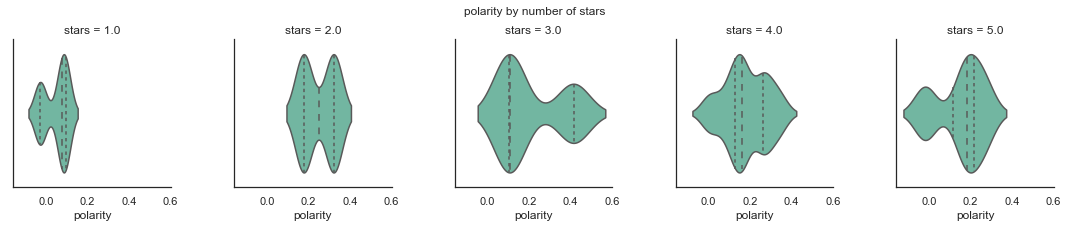

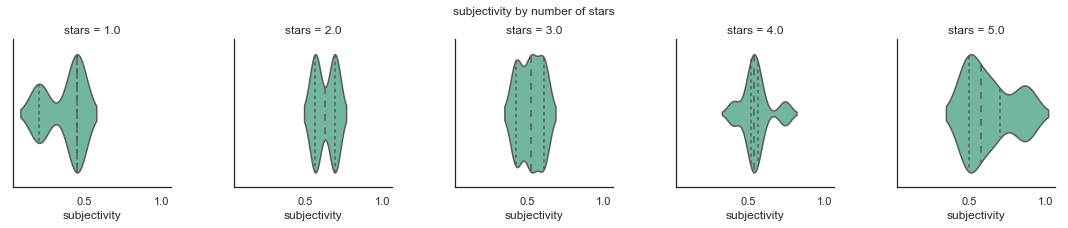

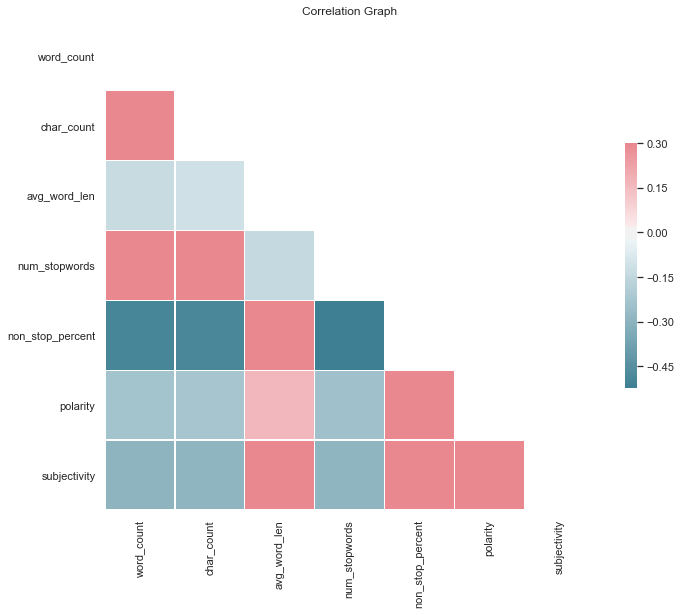

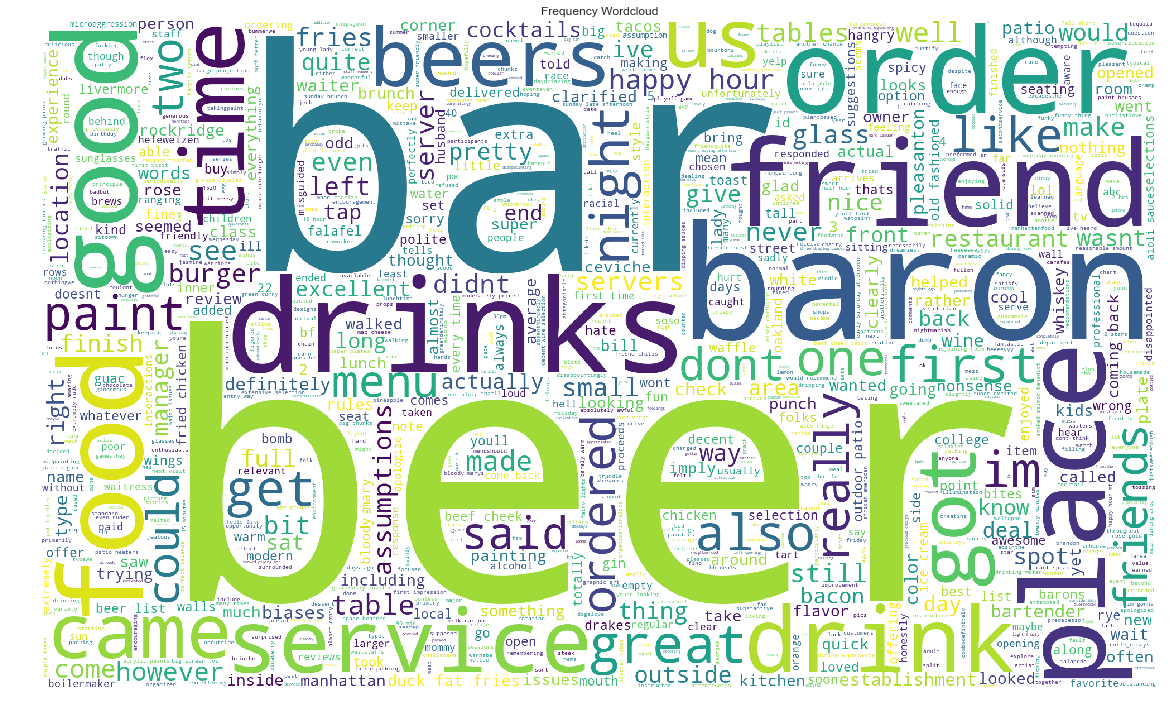

Themes within 1 star reviews
------------
Topic: 0 
Words: 0.037*"beers" + 0.037*"never" + 0.026*"take" + 0.014*"thats" + 0.014*"skip" + 0.014*"supposed" + 0.014*"water" + 0.014*"15 minutes" + 0.014*"would" + 0.014*"told"
Topic: 1 
Words: 0.018*"rather" + 0.013*"sunglasses" + 0.013*"owner" + 0.013*"reviews" + 0.013*"orange" + 0.013*"staff" + 0.013*"serve" + 0.013*"poor" + 0.013*"wait" + 0.007*"happy hour"
Topic: 2 
Words: 0.011*"dont" + 0.011*"manager" + 0.009*"time" + 0.009*"biases" + 0.009*"baron" + 0.009*"also" + 0.009*"im" + 0.009*"server" + 0.007*"lady" + 0.007*"finish"
Topic: 3 
Words: 0.003*"open" + 0.003*"noon" + 0.003*"would" + 0.003*"water" + 0.003*"told" + 0.003*"thats" + 0.003*"arrivedif" + 0.003*"supposed" + 0.003*"skip" + 0.003*"seated"


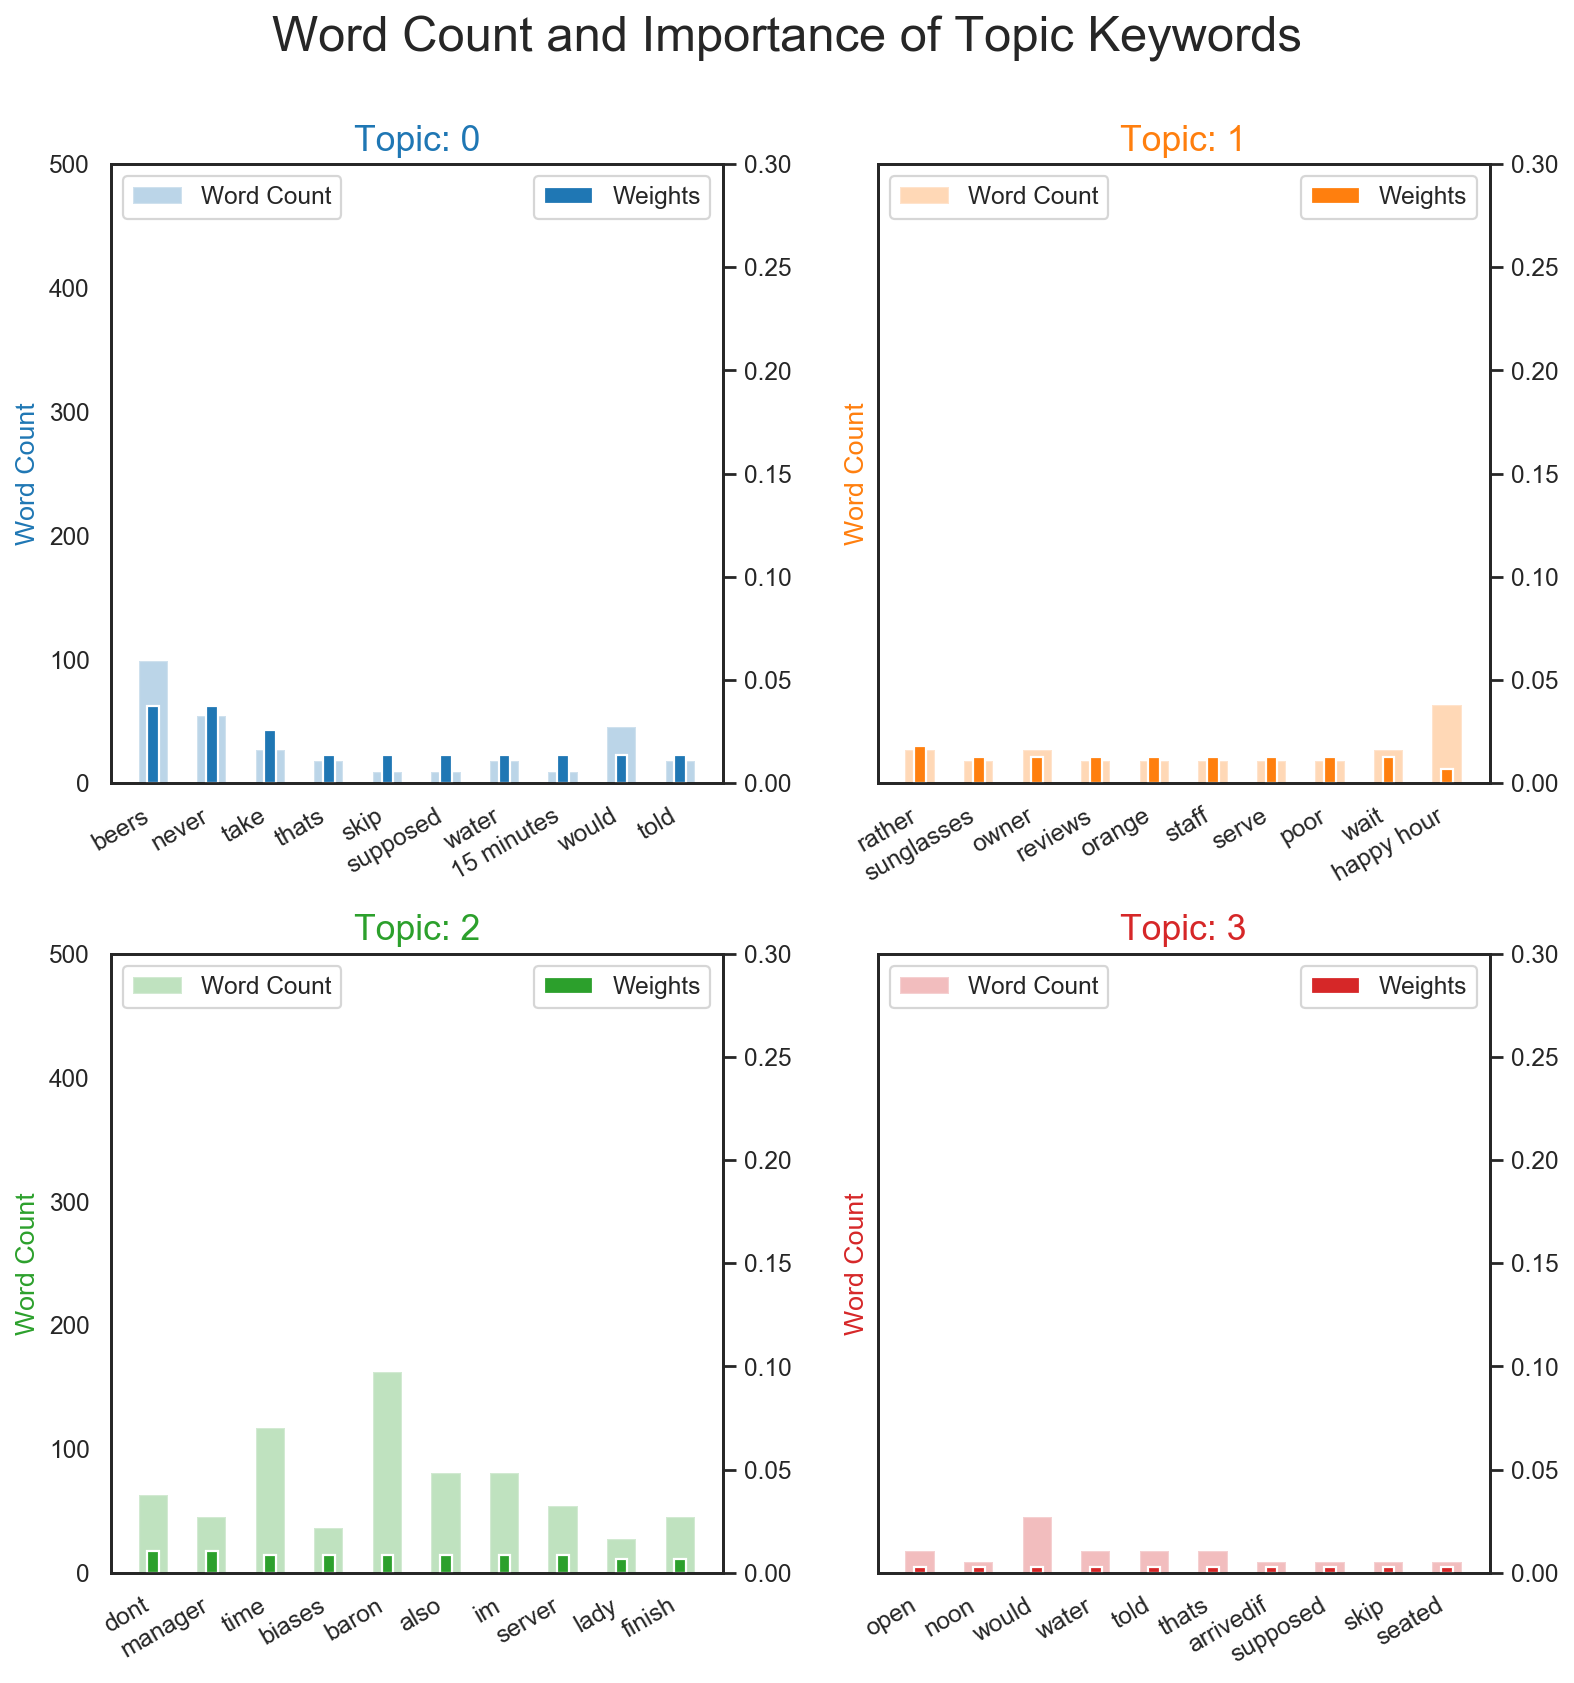

Themes within 5 star reviews
------------
Topic: 0 
Words: 0.008*"excellent" + 0.008*"sorry" + 0.008*"beers" + 0.008*"server" + 0.008*"feel" + 0.008*"dumb" + 0.008*"brandon" + 0.008*"birthday" + 0.008*"drinks" + 0.008*"beer"
Topic: 1 
Words: 0.037*"food" + 0.037*"great" + 0.037*"combodefinitely" + 0.037*"added" + 0.037*"bloody mary" + 0.037*"smoked salmon benedict" + 0.037*"dogslove" + 0.037*"spot" + 0.037*"shops" + 0.037*"neighborhoodhad"
Topic: 2 
Words: 0.033*"beef cheek" + 0.033*"mac cheese" + 0.033*"taco" + 0.033*"sunday brunch" + 0.033*"service" + 0.033*"okra" + 0.033*"mouth" + 0.033*"melted" + 0.033*"meat" + 0.033*"big chunks"
Topic: 3 
Words: 0.026*"server" + 0.026*"feel" + 0.026*"dumb" + 0.026*"brandon" + 0.026*"beers" + 0.026*"birthday" + 0.026*"sorry" + 0.017*"manhattan" + 0.017*"baron" + 0.017*"time"


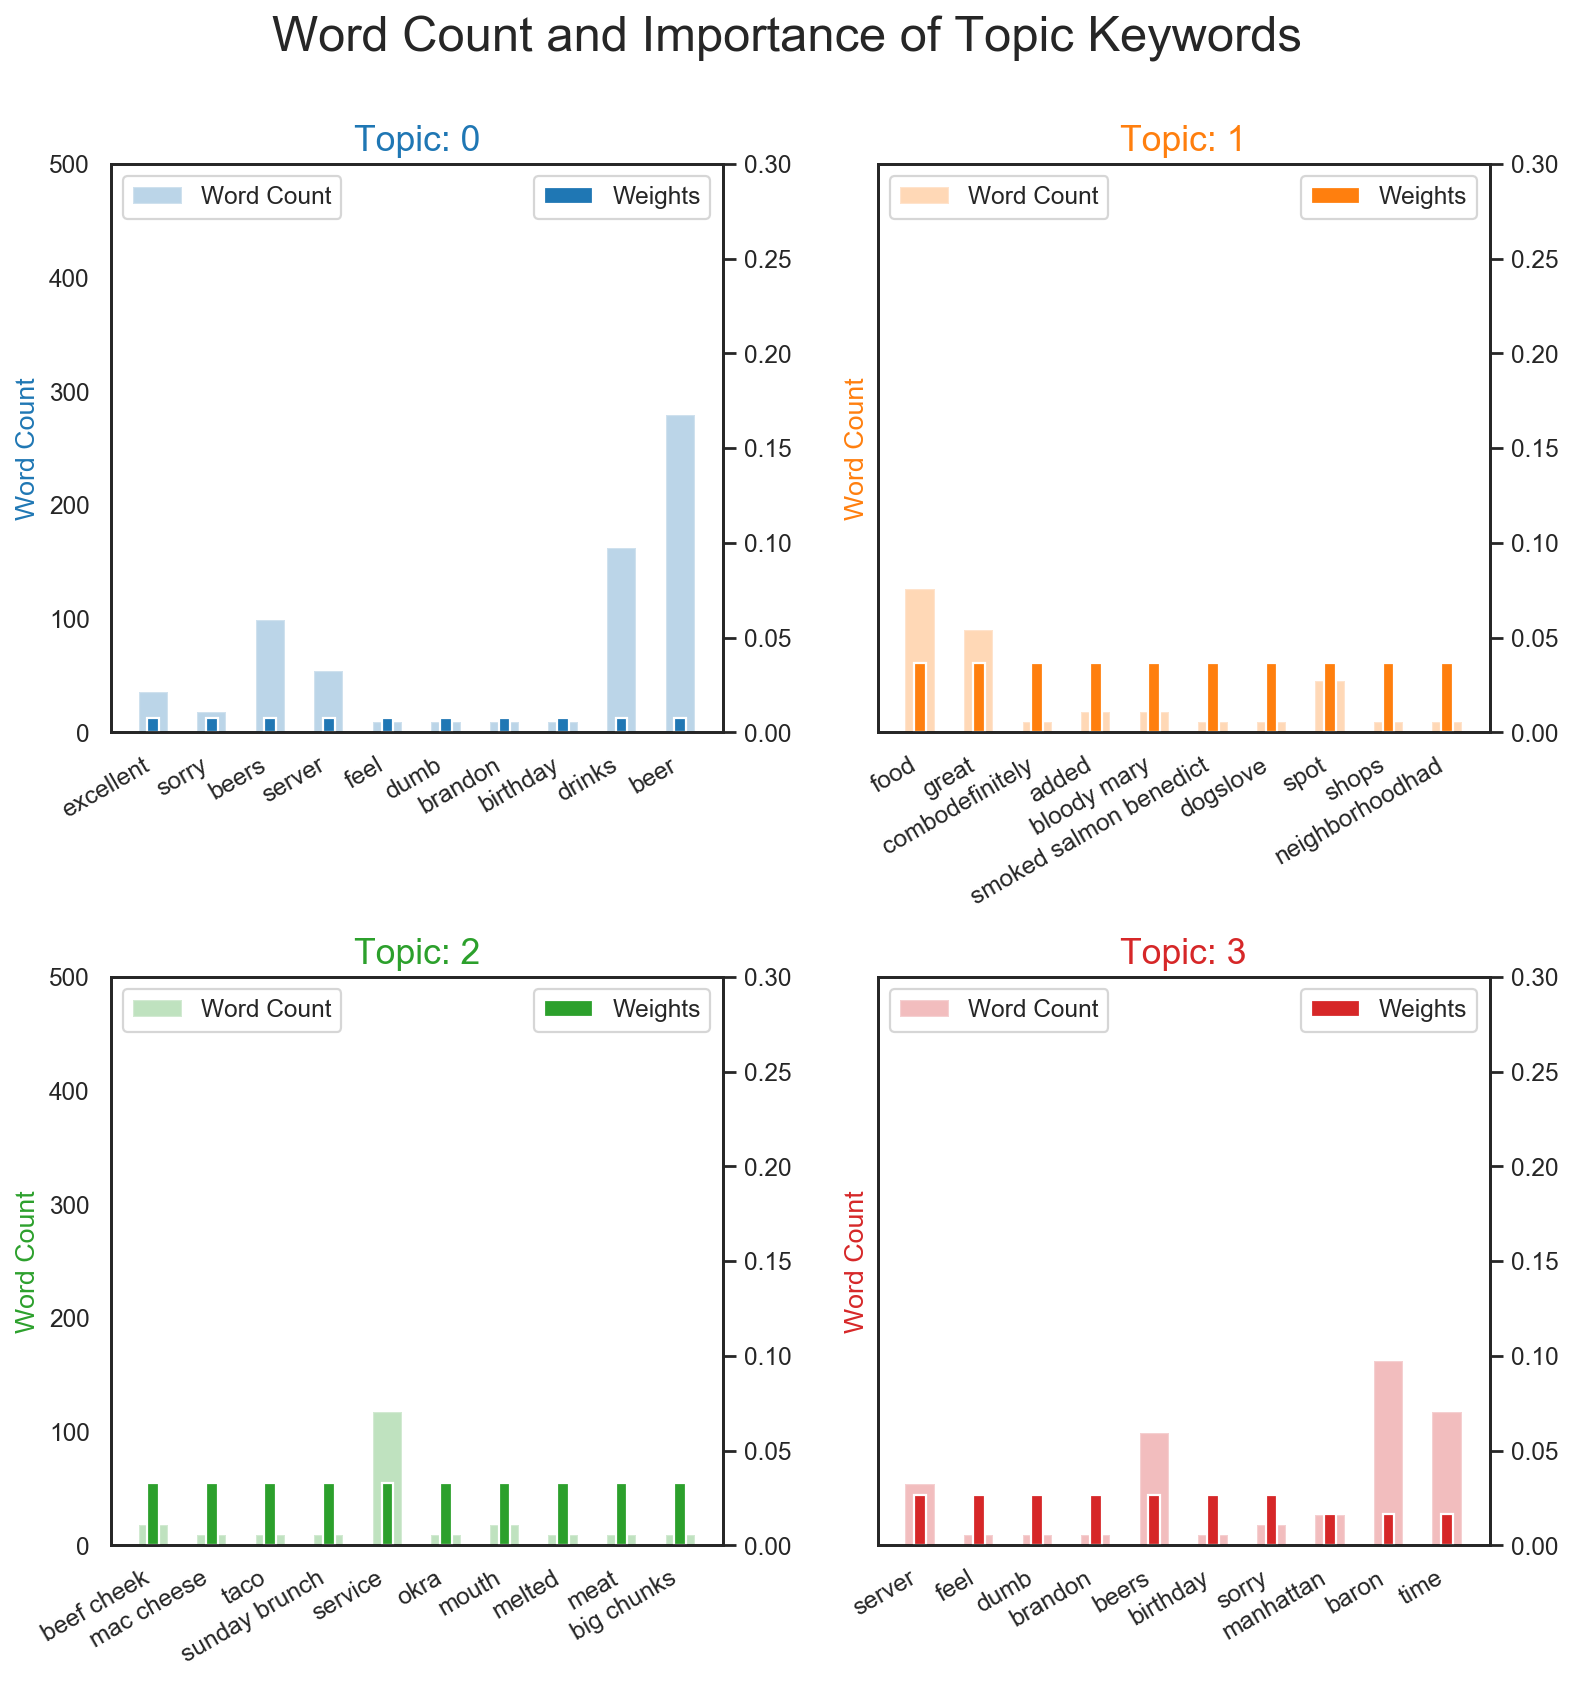

---------------
Text Shape: (180, 50000)
---------------
Model Accuracy: 75.0%
---------------
Model Evaluation
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        27
         2.0       0.50      1.00      0.67         9
         3.0       0.67      0.67      0.67        27
         4.0       0.88      0.70      0.78        90
         5.0       0.50      0.67      0.57        27

   micro avg       0.75      0.75      0.75       180
   macro avg       0.71      0.81      0.74       180
weighted avg       0.79      0.75      0.76       180



In [152]:
get_labels(data,"review","business_1",
           './models/lr_clf_text.sav',
           './models/svc_clf_text.sav',
           data["stars"])